**Human Language Technologies Project**

**Authors:** Dalla Noce Niko, Ristori Alessandro

# **HLT Project**

This work is higly based on the tensorflow tutorial https://www.tensorflow.org/text/tutorials/transformer, our aim was to introduce BERT as an encoder in the model and try combinations with different architectures (both RNNs and transformers).

## **Setup**
We need to install the transformers package to use the models and tokenizers from HuggingFace.

In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 66.8 MB/s 
     |████████████████████████████████| 3.3 MB 47.2 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [2]:
import logging
import sentencepiece
import random
import numpy as np
import tarfile
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
from tensorflow.keras import layers

The model training is going to run on TPUs since they are the optimized for working with tensors, if there are no TPUs avilable then we work with a GPU instead.

In [3]:
# Detect hardware
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.106.216.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.106.216.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.106.216.106:8470']
Number of accelerators:  8


In [4]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

Clone the project repository.

In [5]:
!git clone "https://github.com/nikodallanoce/HLT/"  # clone the project repository

Cloning into 'HLT'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (424/424), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 424 (delta 225), reused 188 (delta 75), pack-reused 0
Receiving objects: 100% (424/424), 32.64 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (225/225), done.


Mount the drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')  # mount the drive

Mounted at /content/drive


Import all the models needed for the project.

In [7]:
def create_encoder_bert():
    with strategy.scope():
        bert_model = TFBertModel.from_pretrained("bert-base-cased")
    return bert_model

def create_encoder_t5():
    with strategy.scope():
        t5_model = TFT5EncoderModel.from_pretrained("t5-base"),
    return t5_model

def create_encoder_xlnet():
    with strategy.scope():
        xlnet_model = TFXLNetModel.from_pretrained("xlnet-base-cased"),
    return xlnet_model

In [8]:
from transformers import BertTokenizer, BertTokenizerFast, TFBertModel, T5TokenizerFast, T5Tokenizer, TFT5EncoderModel, XLNetTokenizerFast, XLNetTokenizer, TFXLNetModel

logging.getLogger("transformers").setLevel(logging.ERROR)  # suppress warning for transformers

encoder_models = {
    "bert": {
        "tokenizer": BertTokenizerFast.from_pretrained("bert-base-cased"),
        "encoder": create_encoder_bert,
        "tokenizer_translation": BertTokenizer.from_pretrained("bert-base-cased"),
    },
    "t5": {
        "tokenizer": T5TokenizerFast.from_pretrained("t5-base"),
        "encoder" : create_encoder_t5,
        "tokenizer_translation" : T5Tokenizer.from_pretrained("t5-base"),
    },
    "xlnet" : {
        "tokenizer" : XLNetTokenizerFast.from_pretrained("xlnet-base-cased"),
        "encoder" : create_encoder_xlnet,
        "tokenizer_translation" : XLNetTokenizer.from_pretrained("xlnet-base-cased"),
    },
}

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

## **Building the training, validation and test set**

We need to build our three sets by preprocessing the en-it anki dataset, tokenizing it and splitting it into training, validation and test.

### **Preprocessing the dataset**

Create two lists containing the sentences of the anki dataset, one in english and one in italian.

Let's define the method to preprocess the anki dataset.

In [9]:
def create_dataset_euparl(name: str, src: str = "en", dst: str = "it", size: float = 1) -> (list, list):
    with open(name+".{0}".format(src), encoding="UTF-8") as datafile:
        src_set = datafile.readlines()

    with open(name+".{0}".format(dst), encoding="UTF-8") as datafile:
        dst_set = datafile.readlines()

    if size != 1:
        if size > 1 or size < 0:
            raise ValueError("No correct size for the euparl corpus")
        
        datasets_to_shuffle = list((zip(src_set, dst_set)))
        np.random.shuffle(datasets_to_shuffle)
        src_set, dst_set = zip(*datasets_to_shuffle)
        src_set = list(src_set[:int(len(src_set) * size)])
        dst_set = list(dst_set[:int(len(dst_set) * size)])

    return src_set, dst_set

def create_dataset_anki(name: str, preprocessed:bool) -> (list, list):
    with open(name, encoding="UTF-8") as datafile:
        src_set = list()
        dst_set = list()
        for sentence in datafile:
            sentence = sentence.split("\t")
            src_set.append(sentence[0])
            if preprocessed:
                dst_set.append(sentence[1].split("\n")[0])
            else:
                dst_set.append(sentence[1])

    return src_set, dst_set

def merge_datasets(first_dataset, second_dataset) -> (list, list):
    first_src, first_dst = first_dataset
    second_src, second_dst = second_dataset
    src_set = first_src + second_src
    dst_set = first_dst + second_dst
    return src_set, dst_set

The dataset is in the project repository inside a zip file, we need to extract it and then we can build our lists using the previous method.

In [10]:
fname = "/content/drive/Shareddrives/HLT/datasets/it-en.tar"
tar = tarfile.open(fname, "r:")
tar.extractall()
tar.close()

In [11]:
import zipfile
with zipfile.ZipFile("HLT/dataset/dataset_anki_it.zip", 'r') as zip_ref:
    zip_ref.extractall("")

en_set_anki, it_set_anki = create_dataset_anki("ita_preprocessed.txt", True)
en_set_euparl, it_set_euparl = create_dataset_euparl("europarl-v7.it-en", size=0.2)
en_set, it_set = merge_datasets((en_set_anki, it_set_anki), (en_set_euparl, it_set_euparl))
print("The corpus' size is: {0}".format(len(en_set)))

The corpus' size is: 733863


### **Dataset tokenization**

We tokenize each sentence in the two lists by using the tokenizers from huggingface.

Before we create the dataset from our lists, we have to tokenize each sentence from the corpus by using the BERT tokenizer for english and the one for italian. Moreover we can get the number of tokens for both source and target.

In [12]:
encoder_model = encoder_models["bert"]
ita_src = "dbmdz/bert-base-italian-cased"

In [13]:
# Create the tokenizers and get the number of tokens
tokenizer_en = encoder_model["tokenizer"]
tokenizer_it = BertTokenizerFast.from_pretrained(ita_src)
v_size_en = tokenizer_en.vocab_size
v_size_it = tokenizer_it.vocab_size

print("Number of tokens for the english dataset: {0}".format(v_size_en))
print("Number of tokens for the italian dataset: {0}".format(v_size_it))

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Number of tokens for the english dataset: 28996
Number of tokens for the italian dataset: 31102


Let's calculate the max number of tokens allowed, this number is taken such that 99% of the sentences in the dataset are fully tokenized.

In [14]:
def set_max_tokens(dataset: list, language: str = "en") -> int:
    len_sentences = [len(sentence.split()) for sentence in dataset]
    mean_len_sentences = np.mean(len_sentences)
    print("{0} dataset average sentence length: {1}".format(language, mean_len_sentences))
    max_length = int(mean_len_sentences + 2 * np.std(len_sentences))
    print("{0} dataset max length allowed: {1}".format(language, max_length))
    return max_length

max_length_en = set_max_tokens(en_set, "en")
max_length_it = set_max_tokens(it_set, "it")

en dataset average sentence length: 16.21434790962346
en dataset max length allowed: 46
it dataset average sentence length: 15.673587576972814
it dataset max length allowed: 45


Tokenize the source and target dataset.

In [15]:
# Tokenize the dataset
# max_length = np.max([max_length_en, max_length_it])  # use just one of the max length allowed
max_length = 80
with strategy.scope():
    tokens_en = tokenizer_en(en_set, add_special_tokens=True, truncation=True, padding="max_length",
                              return_tensors="tf", max_length=max_length).data["input_ids"]
    tokens_it = tokenizer_it(it_set, add_special_tokens=True, truncation=True, padding="max_length",
                              return_tensors="tf", max_length=max_length+1).data["input_ids"]

Let's show some sentences from both languages and how they were tokenized.

In [16]:
for _ in range(3):
  i = np.random.randint(len(tokens_en))
  print("En sentence: {0}\nTokenized sentence: {1}".format(en_set[i], tokens_en[i]))
  print("It sentence: {0}\nTokenized sentence: {1}\n".format(it_set[i], tokens_it[i]))

En sentence: I know Tom is in lots of trouble.
Tokenized sentence: [ 101  146 1221 2545 1110 1107 7424 1104 3819  119  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
It sentence: Lo so che Tom è in un mare di guai.
Tokenized sentence: [ 102  621  245  158 4024  198  139  141 2337  120 8747  697  103    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]

En sentence: Then there are another 13 whose

### **Splitting the dataset**

Then we build the tf dataset and split it into training, validation and test sets.

In [17]:
def split_set(dataset: tf.data.Dataset,
              tr: float = 0.8,
              val: float = 0.1,
              ts: float = 0.1,
              shuffle: bool = True) -> (tf.data.Dataset, tf.data.Dataset, tf.data.Dataset):
    if tr+val+ts != 1:
        raise ValueError("Train, validation and test partition not allowed with such splits")

    dataset_size = dataset.cardinality().numpy()
    if shuffle:
        dataset = dataset.shuffle(dataset_size)

    tr_size = int(tr * dataset_size)
    val_size = int(val * dataset_size)

    tr_set = dataset.take(tr_size)
    val_set = dataset.skip(tr_size).take(val_size)
    ts_set = dataset.skip(tr_size).skip(val_size)
    return tr_set, val_set, ts_set

In [18]:
# Build the dataset and split it in train, validation and test
dataset = tf.data.Dataset.from_tensor_slices((tokens_en, tokens_it))  # build the tf dataset
tr_set, val_set, ts_set = split_set(dataset, 0.8, 0.1, 0.1)  # split the tf dataset
print("Training set size: {0}".format(len(tr_set)))
print("Validation set size: {0}".format(len(val_set)))
print("Test set size: {0}".format(len(ts_set)))

Training set size: 587090
Validation set size: 73386
Test set size: 73387


### **Create training and validation batches**

After we have built our development and test set, we need to split the first one (both training and validation) in batches.


In [19]:
def format_dataset(eng, ita):
    return ({"encoder_inputs": eng, "decoder_inputs": ita[:, :-1],}, ita[:, 1:])

def make_batches(dataset_src_dst: tf.data.Dataset, batch_size: int) -> tf.data.Dataset:
    dataset = dataset_src_dst.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.prefetch(tf.data.experimental.AUTOTUNE).cache()

In [20]:
batch_size =  16 * strategy.num_replicas_in_sync

with strategy.scope():
    tr_batches = make_batches(tr_set, batch_size)
    val_batches = make_batches(val_set, batch_size)

In [21]:
for src, dst in tr_batches.take(1):
    print("encoder inputs shape: {0}".format(src["encoder_inputs"].shape))
    print("decoder inputs shape: {0}".format(src["decoder_inputs"].shape))
    print("targets shape: {0}".format(dst.shape))

encoder inputs shape: (128, 80)
decoder inputs shape: (128, 80)
targets shape: (128, 80)


## **Layers**

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together.

### **Positional embeddings layer**

To make the model aware of word order, we also use a PositionalEmbedding layer.

In [22]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, v_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=v_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.v_size = v_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### **Encoder**

The source sequence will be pass to the TransformerEncoder, which will produce a new representation of it. This new representation will then be passed to the TransformerDecoder, together with the target sequence so far (target words 0 to N). 

The single layer of the encoder transformer.

In [23]:
class EncoderLayer(layers.Layer):

    def __init__(self, layers_size: int, dense_size: int, num_heads: int, dropout=0.1, **kwargs) -> None:
        super(EncoderLayer, self).__init__(**kwargs)
        
        self.layers_size = layers_size
        self.dense_size = dense_size
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads, layers_size, dropout=dropout)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_size, activation="relu"), layers.Dropout(dropout), layers.Dense(layers_size)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, mask=None) -> tf.Tensor:
        if mask is not None:  
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        else:
            print("Mask not built")
            assert False
        
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

The encoder transformer.

In [24]:
class EncoderTransformer(layers.Layer):

    def __init__(self,
                 num_layers: int,
                 layers_size: int,
                 dense_size: int,
                 num_heads: int,
                 max_length: int,
                 v_size_src: int,
                 dropout: float = 0.1) -> None:
        super(EncoderTransformer, self).__init__()

        self.layers_size = layers_size
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(max_length, v_size_src, layers_size)
        self.enc_layers = [EncoderLayer(layers_size, dense_size, num_heads) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, mask=None) -> tf.Tensor:
        src_embeddings = self.pos_embedding(inputs)
        enc_out = self.dropout(src_embeddings)
        for i in range(self.num_layers):
            enc_out = self.enc_layers[i](enc_out)

        return enc_out  # (batch_size, input_seq_len, layers_size)

### **Decoder**

The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

The single layer of the decoder transformer.

In [25]:
class DecoderLayer(layers.Layer):

    def __init__(self, layers_size: int, dense_size: int, num_heads: int, dropout=0.1, **kwargs) -> None:
        super(DecoderLayer, self).__init__(**kwargs)
        
        self.layers_size = layers_size
        self.dense_size = dense_size
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads, layers_size, dropout=dropout)
        self.attention_2 = layers.MultiHeadAttention(num_heads, layers_size, dropout=dropout)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_size, activation="relu"), layers.Dropout(dropout), layers.Dense(layers_size)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, encoder_outputs: tf.Tensor, mask=None) -> tf.Tensor:
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

The decoder transformer.

In [26]:
class DecoderTransformer(layers.Layer):

    def __init__(self,
                 num_layers: int,
                 layers_size: int,
                 dense_size: int,
                 num_heads: int,
                 max_length: int,
                 v_size_dst: int,
                 dropout=0.1) -> None:
        super(DecoderTransformer, self).__init__()

        self.layers_size = layers_size
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(max_length, v_size_dst, layers_size)
        self.dec_layers = [DecoderLayer(layers_size, dense_size, num_heads) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, enc_output: tf.Tensor, mask=None) -> tf.Tensor:
        dst_embeddings = self.pos_embedding(inputs)
        dec_output = self.dropout(dst_embeddings)
        for i in range(self.num_layers):
            dec_output = self.dec_layers[i](dec_output, enc_output)

        return dec_output

## **Building the model**

Next, we assemble the end-to-end model.

In [27]:
with strategy.scope():
    encoder = encoder_model["encoder"]()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

In [28]:
def create_model(layers_size: int, num_layers: int, dense_size: int, num_heads: int, max_length: int, encoder=None) -> tf.keras.Model:
    # Encoder
    encoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    if encoder is not None: 
        outputs = encoder(encoder_inputs)
        encoder_outputs = outputs.last_hidden_state
        layers_size = encoder_outputs.shape[-1]  # the size of the encoder and decoder layers must be the same
    else:
        encoder_outputs = EncoderTransformer(num_layers, layers_size, dense_size, num_heads, max_length, v_size_en)(encoder_inputs)

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = tf.keras.Input(shape=(None, layers_size), name="decoder_state_inputs")
    decoder_outputs = DecoderTransformer(num_layers, layers_size, dense_size, num_heads, max_length, v_size_it)(decoder_inputs, encoded_seq_inputs)
    decoder_outputs = layers.Dense(v_size_it, activation="softmax")(decoder_outputs)
    decoder = tf.keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="decoder_transformer")

    # Final model
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
    return transformer

In [ ]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    transformer = create_model(512, 6, 2048, 8, max_length)
    transformer.summary()
    transformer.compile(opt, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_transformer (EncoderTr  (None, None, 512)   77905920    ['encoder_inputs[0][0]']         
 ansformer)                                                                                       
                                                                                                  
 decoder_transformer (Functiona  (None, None, 31102)  145354110  ['decoder_inputs[0][0]'

## **Training the model**

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

In [31]:
with strategy.scope():
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./base_20.h5', save_weights_only = True, monitor='val_loss', mode='auto', save_best_only=True)

In [34]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    transformer.compile(opt, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
epochs = 10  # This should be at least 30 for convergence
transformer.fit(tr_batches, epochs=epochs, validation_data = val_batches, callbacks=[model_checkpoint_callback])

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 80) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 80) dtype=int32>]


4587/4587 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.6947

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 80) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 80) dtype=int32>]


4587/4587 [==============================] - 1288s 260ms/step - loss: 0.3752 - accuracy: 0.6947 - val_loss: 0.3165 - val_accuracy: 0.7289
Epoch 2/10
4587/4587 [==============================] - 1096s 239ms/step - loss: 0.3380 - accuracy: 0.7134 - val_loss: 0.2961 - val_accuracy: 0.7407
Epoch 3/10
4587/4587 [==============================] - 1096s 239ms/step - loss: 0.3144 - accuracy: 0.7257 - val_loss: 0.2801 - val_accuracy: 0.7501
Epoch 4/10
4587/4587 [==============================] - 1098s 239ms/step - loss: 0.2957 - accuracy: 0.7361 - val_loss: 0.2680 - val_accuracy: 0.7576
Epoch 5/10
4587/4587 [==============================] - 1093s 238ms/step - loss: 0.2799 - accuracy: 0.7451 - val_loss: 0.2565 - val_accuracy: 0.7655
Epoch 6/10
4587/4587 [==============================] - 1096s 239ms/step - loss: 0.2660 - accuracy: 0.7533 - val_loss: 0.2474 - val_accuracy: 0.7717
Epoch 7/10
4587/4587 [==============================] - 1097s 239ms/step - loss: 0.2535 - accuracy: 0.7610 - val_loss

In [37]:
ts_loss, ts_accuracy = transformer.evaluate(make_batches(ts_set, batch_size))
print("Test loss: {0}\nTest accuracy: {1}".format(ts_loss, ts_accuracy))

574/574 [==============================] - 40s 65ms/step - loss: 0.2161 - accuracy: 0.7959
Test loss: 0.21611766517162323
Test accuracy: 0.7959085702896118


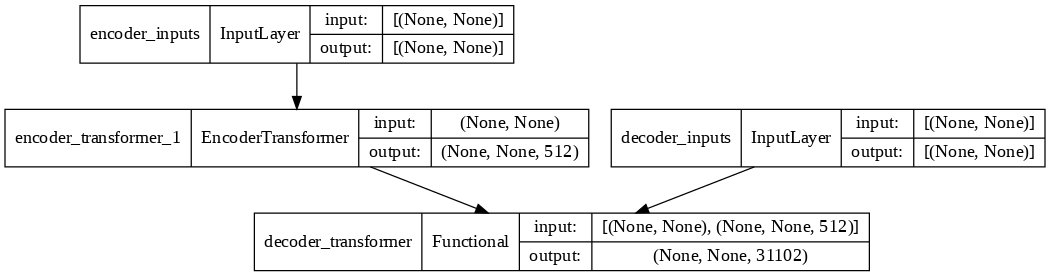

In [ ]:
tf.keras.utils.plot_model(
    transformer, to_file='base.png', show_shapes=True, dpi=90
)

In [36]:
transformer.save_weights('/content/drive/Shareddrives/HLT/models/base_20.h5', overwrite=True)

## **Translator**

In [30]:
tokenizer_it = BertTokenizer.from_pretrained(ita_src)
with strategy.scope():
  transformer = create_model(512, 6, 2048, 8, 80)
  transformer.load_weights('/content/drive/Shareddrives/HLT/models/base.h5')

In [38]:
class Translator(tf.Module):

    def __init__(self, tokenizer_src, tokenizer_dst, max_length: int, transformer: tf.keras.Model) -> None:
        super(Translator, self).__init__()
        self.tokenizer_src = tokenizer_src
        self.tokenizer_dst = tokenizer_dst
        self.max_length = max_length
        self.transformer = transformer

    def translate(self, input_sentence: str, k: int = 1) -> (list, str):
        tokenized_input_sentence = self.tokenizer_src(input_sentence, return_tensors='tf', add_special_tokens=True,
                                                      max_length=self.max_length, padding='max_length',
                                                      truncation=True).data["input_ids"]
        decoded_sentence = "[CLS]"
        list_tokens = [decoded_sentence]
        for i in range(self.max_length):
            decoded_sentence = self.tokenizer_dst.convert_tokens_to_string(list_tokens)
            tokenized_dst_sentence = self.tokenizer_dst(decoded_sentence, return_tensors='tf', add_special_tokens=False,
                                                        max_length=self.max_length,
                                                        padding='max_length', truncation=True).data['input_ids']
            predictions = self.transformer([tokenized_input_sentence, tokenized_dst_sentence])
            sampled_token_indexes = np.argsort(predictions[0, i, :])[-k:]
            p = [float(predictions[0, i, j]) for j in sampled_token_indexes]
            p = np.array(p)
            p /= np.sum(p)
            sampled_token_index = np.random.choice(sampled_token_indexes, 1, p=p)
            sampled_token = self.tokenizer_dst.ids_to_tokens[sampled_token_index[0]]
            if sampled_token == "[SEP]":
                decoded_sentence = self.tokenizer_dst.convert_tokens_to_string(list_tokens[1:])
                break

            list_tokens.append(sampled_token)

        return list_tokens, decoded_sentence
    
    def translate_beam_search(self, input_sentence: str, k=2):
      tokenized_input_sentence = self.tokenizer_src(input_sentence, return_tensors='tf', add_special_tokens=True, max_length=self.max_length,
                        padding='max_length', truncation=True).data["input_ids"]
      decoded_sentence = (["[CLS]"], 1)
      beam_queue = SimpleQueue()
      beam_queue.put(decoded_sentence)
      translated = list()
      i = 0
      while not beam_queue.empty() and i < self.max_length:
          tokenized_sentence, prb = beam_queue.get()
          decoded_sentence = self.tokenizer_dst.convert_tokens_to_string(tokenized_sentence)
          tokenized_target_sentence = self.tokenizer_dst(decoded_sentence, return_tensors='tf', add_special_tokens=False, max_length=self.max_length,
                            padding='max_length').data['input_ids']
          predictions = self.transformer([tokenized_input_sentence, tokenized_target_sentence])
          i = len(tokenized_sentence) - 1
          sampled_token_indexes = np.argsort(predictions[0, i, :])[-k:]
          probabilities = [float(predictions[0, i, j]) for j in sampled_token_indexes]
          for samp_index, p in zip(sampled_token_indexes, probabilities):
              sampled_token = self.tokenizer_dst.ids_to_tokens[samp_index]
              tok_sent_with_new_samp = tokenized_sentence.copy()
              tok_sent_with_new_samp.append(sampled_token)
              next_sent = (tok_sent_with_new_samp, p * prb)
              if sampled_token == "[SEP]":  # and next_sent[1] > 0.02:
                  translated.append(next_sent)
              elif next_sent[1] > 0.001:
                  beam_queue.put(next_sent)

      translated.sort(key=lambda x: x[1], reverse=True)
      return translated

In [42]:
with strategy.scope():
    translator = Translator(encoder_model["tokenizer_translation"], BertTokenizer.from_pretrained(ita_src), 80, transformer)

en = "I saw a bed in your bedroom and it was amazing, where did you buy it?"
out_translation = translator.translate(en)
print(out_translation[-1])

Ho visto un letto nella tua camera da letto ed era sorprendente , dove lo avete comprato ?


## **Bleu score**

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
marian_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-it")
marian_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-it")

In [ ]:
import tarfile
fname = "/content/drive/Shareddrives/HLT/evaluation/flores101_dataset.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
with open("/content/flores101_dataset/devtest/eng.devtest", encoding="UTF-8") as datafile:
    src_test = list()
    for sentence in datafile:
        src_test.append(sentence)

In [ ]:
len_sentences = [len(sentence.split()) for sentence in src_test]
max_length_test = np.max(len_sentences)
max_length_test

60

In [ ]:
dst_out = list()
for sentence in tqdm_notebook(src_test):
    translated = marian_model.generate(**marian_tokenizer(sentence, return_tensors="pt", padding=True))
    translation = [marian_tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    dst_out.append("".join(translation))

  0%|          | 0/1012 [00:00<?, ?it/s]

In [ ]:
tokenized_test = tokenizer_en(src_test, return_tensors = 'tf', padding = True, add_special_tokens = True).data["input_ids"]
tokenized_test

<tf.Tensor: shape=(1012, 76), dtype=int32, numpy=
array([[  101,   107,  1284, ...,     0,     0,     0],
       [  101,  1987,   119, ...,     0,     0,     0],
       [  101,  2409,  1199, ...,     0,     0,     0],
       ...,
       [  101, 27331,  1116, ...,     0,     0,     0],
       [  101,  6955, 11256, ...,     0,     0,     0],
       [  101,  8736,  1538, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
tokenizer_it = BertTokenizer.from_pretrained(ita_src)
with strategy.scope():
    transformer = create_model(512, 6, 2048, 8, 80)
    transformer.load_weights('drive/Shareddrives/HLT/models/base.h5')
    translator = Translator(encoder_model["tokenizer_translation"], BertTokenizer.from_pretrained(ita_src), 80, transformer)

In [ ]:
dst_out = list()
for sentence in tqdm_notebook(src_test):
    dst_out.append(translator.translate(sentence)[-1])

  0%|          | 0/1012 [00:00<?, ?it/s]

In [ ]:
with open("translation_base_20.txt", "w", encoding="UTF-8") as datafile:
    for sentence in dst_out:
        datafile.write("{0}\n".format(sentence))

In [ ]:
!git clone --single-branch --branch adding_spm_tokenized_bleu https://github.com/ngoyal2707/sacrebleu.git
%cd sacrebleu
!python setup.py install
%cd ../

Cloning into 'sacrebleu'...
remote: Enumerating objects: 1087, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1087 (delta 0), reused 5 (delta 0), pack-reused 1081
Receiving objects: 100% (1087/1087), 378.97 KiB | 3.71 MiB/s, done.
Resolving deltas: 100% (715/715), done.
/content/sacrebleu
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating sacrebleu.egg-info
writing sacrebleu.egg-info/PKG-INFO
writing dependency_links to sacrebleu.egg-info/dependency_links.txt
writing entry points to sacrebleu.egg-info/entry_points.txt
writing requirements to sacrebleu.egg-info/requires.txt
writing top-level names to sacrebleu.egg-info/top_level.txt
writing manifest file 'sacrebleu.egg-info

In [ ]:
!cat translation_base_20.txt | sacrebleu -tok spm flores101_dataset/devtest/ita.devtest --force --score-only

10.2
